# Experiment 2: Modelling with and without causality

Same as Experiment 1, but changing the causal graph so that modelling only with X brings bad results, and modelling y X and B works as expected.

The experiment has the following steps:
1. Define a causal graph (Directed Acyclic graph) relating five (5) hypothetical variables. Some of them will be supposed to be unknown.
1. Define causal rules between those variables
1. Generate a data set following the rules
1. Train a general ML model on the data set in order to predict the effect of X into Y
1. Train a general ML model on the data set using the causal information in order to predict the effect of X into Y.
1. Compare the performance of the two approaches:
 1. On unseen data that follows the distribution of the training set
 1. On unseen data that does not follow the distribution of the training set

## 1. Define a causal graph

Here I define a causal graph whose relations may cause problems if not adequately treated. Nodes in gray will not be visible in the dataset.

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import plotly_express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import networkx as nx
from nxpd import draw

# np.random.seed(seed=42) # Test set is not representative
np.random.seed(seed=22)

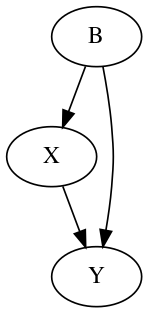

In [2]:
G = nx.DiGraph()
G.graph['dpi'] = 120
G.add_nodes_from(['X', 'B', 'Y'])
G.add_edges_from([('B','X'),('B','Y'),('X','Y')])
draw(G, show='ipynb')

The problem presented to the ML practitioner will be:

**Can you estimate the real influence of X in Y?**  
**I mean, what happens to Y when I increase X by one unit, keeping all the same equal?**

## 2-3. Define causal rules between variables and create data set

Let's define some rules to later generate a data set:

In [3]:
n = 10000

In [4]:
sigma_B = 8
mu_B = 3
B = sigma_B * np.random.randn(n,1) + mu_B

In [5]:
X = 2*B + np.random.randn(n,1)
Y = X - 3*B + np.random.randn(n,1)

In [6]:
df_data = np.concatenate((B,X,Y), axis=1)
df = pd.DataFrame(data=df_data, columns=['B','X','Y'])
df.head()

B          X         Y
0   2.264401   3.881231 -3.567326
1  -8.706805 -17.380614  9.223865
2  11.654333  25.087367 -8.811545
3   1.085399   1.845496 -1.021140
4  -0.929033  -3.126144 -1.172662

## Prepare training set

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Y'), df[['Y']], test_size=0.3, random_state=42)

In [8]:
y_train = np.squeeze(y_train)
y_test  = np.squeeze(y_test)

## Explore data set

In [9]:
pp.ProfileReport(df, style={'full_width':True})

In [10]:
px.scatter(data_frame=df, x='X', y='Y')

In [11]:
px.scatter(data_frame=df, x='B', y='Y')

## 4. Train using X and B (what causal inference recommends)

Let's try a Linear Regression. Both X and mainly B are highly correlated with Y, so I will use both variables:

In [12]:
causal_linear_model = LinearRegression()
causal_linear_model.fit(X_train, y_train)
predictions_causal_linear_model = causal_linear_model.predict(X_test)
print("MAE in test set = {}".format(np.round(mean_absolute_error(predictions_causal_linear_model, y_test), decimals=3)))

MAE in test set = 0.781


It looks like the model has learned the patterns in the data set.

In [13]:
X_train.columns

Index(['B', 'X'], dtype='object')

In [14]:
causal_linear_model.coef_

array([-3.0481759 ,  1.02206526])

The model says that for each extra unit of X, Y is expected to decrease by 1.02 units.
And for each extra unit of B, Y is expected to decrease by 3.04 units.

Remember that:

**Y = X - 3*B**

So the model captures the underlying patterns perfectly!

## 5. Train a general ML model using only X

Let's try the same model, but training only on X:

In [15]:
X_train_anticausal = X_train[['X']]
X_test_anticausal = X_test[['X']]

In [16]:
anticausal_linear_model = LinearRegression()
anticausal_linear_model.fit(X_train_anticausal, y_train)
predictions_anticausal_linear_model = anticausal_linear_model.predict(X_test_anticausal)
print("MAE in Test set = {}".format(np.round(mean_absolute_error(predictions_anticausal_linear_model, y_test), decimals=2)))

MAE in Test set = 1.46


The model is quite worse when predicting Y (as expected; it is only considering the influence of X).

In [17]:
anticausal_linear_model.coef_

array([-0.49788753])

This time, the model predicts that for each unit increment in X, Y is expected to decrease by -0.5, which is a much worse approximation to the real effect value (1).

## 6A. Performance comparison with unseen data similar to the training set
Let's take a reference value:

In [18]:
X_test.head(1)

B         X
6252  2.143471  4.558099

What would happen if I increase X by one unit?

In [19]:
do_X_test = X_test.copy()
do_X_test[['X']] = do_X_test[['X']] + 5.

In [20]:
do_X_test.head(1)

B         X
6252  2.143471  9.558099

**Anticausal answer:**

In [21]:
predictions_anticausal = anticausal_linear_model.predict(do_X_test[['X']])

**Causal inference answer:** 

In [22]:
predictions_causal_inference = y_test + 5 * 1.02

**Real answer:**  



In [23]:
real_answer = do_X_test.X - 3.0 * do_X_test.B

In [24]:
print("MAE ML: {}".format(np.round(mean_absolute_error(real_answer, predictions_anticausal), decimals=2)))
print("MAE Causal Inference: {}".format(np.round(mean_absolute_error(real_answer, predictions_causal_inference), decimals=2)))

MAE ML: 7.48
MAE Causal Inference: 0.79


The causal inference method performs much better!  
This is not surprising after seeing the estimation of coefficients made by each method.

# Conclusion

This is a very simple (silly?) experiment, but shows some important truths: 

1. Machine learning models (statistics in general) are very good at predicting when the unseen data is similar to the training data set, but they don't necessarily capture the real underlying patterns.

2. If we want to predict what will happen if we change a variable, ML will not help, as we are artificially changing the data set distribution.

3. Causal inference is like an extra dimension that lets us see things we couldn't see before.